# Logistic Regression Model Training and Evaluation (Enhanced)

This notebook trains a Multinomial Logistic Regression model on the preprocessed disease-symptom data and provides a comprehensive evaluation including:
- Data Loading and Preparation
- Cross-Validation Performance
- Detailed Classification Metrics
- Confusion Matrix Visualization
- Feature Importance Analysis
- Learning Curve Analysis
- ROC Curve and AUC Score (One-vs-Rest)

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from itertools import cycle

# Set plot style
plt.style.use('ggplot')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Prepare Data

In [4]:
file_path = '../../data/processed/Cleaned_Diseases_preprocessed_Data.csv'
diseases_df = pd.read_csv(file_path)

# Encode Disease column into numerical labels
le = LabelEncoder()
diseases_df["DiseaseEncoded"] = le.fit_transform(diseases_df["Disease"])

# Define features (X) and target (y)
X = diseases_df.drop(columns=["Disease", "DiseaseEncoded"])
y = diseases_df["DiseaseEncoded"]
feature_names = X.columns
class_names = le.classes_
n_classes = len(class_names)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of classes: {n_classes}")

Features shape: (4920, 33)
Target shape: (4920,)
Number of classes: 41


## 3. Define Model and Cross-Validation Strategy

In [5]:
# Define the Logistic Regression model
clf = LogisticRegression(
    multi_class='multinomial',  # Suitable for multi-class problems
    solver='lbfgs',             # Efficient solver
    class_weight='balanced',    # Adjusts weights inversely proportional to class frequencies
    max_iter=1000,              # Increased iterations for convergence
    random_state=42
)

# Define cross-validation strategy (e.g., 5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. Cross-Validation Performance

In [6]:
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation CV Accuracy: {cv_scores.std():.4f}")

Performing 5-fold cross-validation...

Cross-Validation Accuracy Scores: [0.90243902 0.89939024 0.90142276 0.90447154 0.89837398]
Mean CV Accuracy: 0.9012
Standard Deviation CV Accuracy: 0.0022


## 5. Train on Full Data (for detailed metrics and plots)

In [8]:
# Split data for detailed evaluation (using stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training model on the training split...")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

print("Model training complete.")

Training model on the training split...
Model training complete.


## 6. Detailed Classification Metrics

In [9]:
print("Classification Report (on test set):\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report (on test set):

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       0.34      0.92      0.49        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       0.89      1.00      0.94        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      0.08      0.15        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.00      1.00

## 7. Confusion Matrix Visualization

Confusion Matrix (on test set):



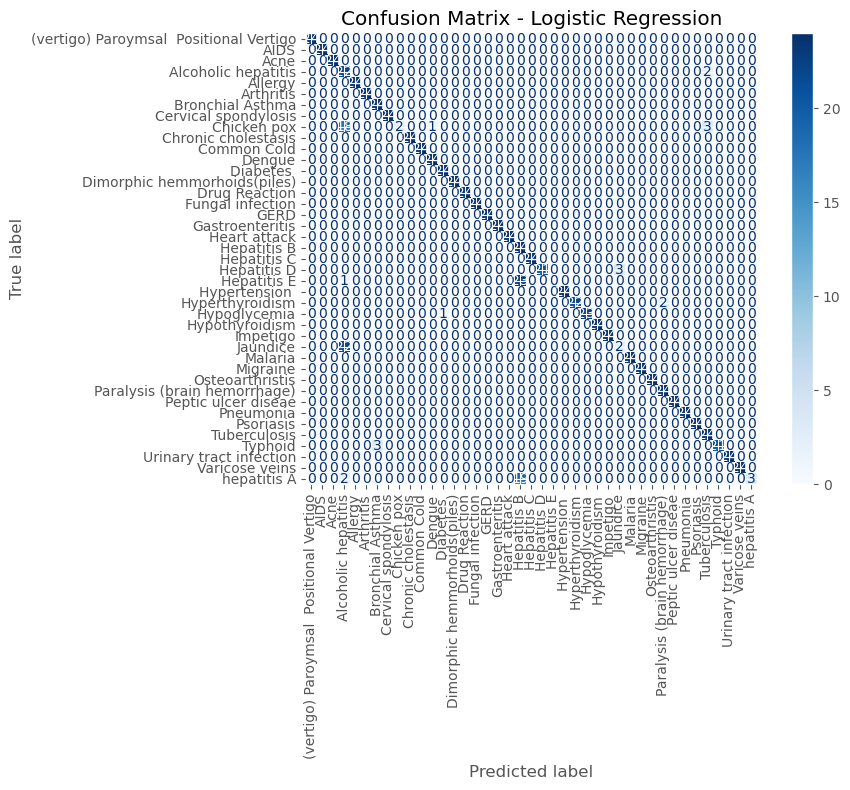

In [9]:
print("Confusion Matrix (on test set):\n")
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

For Logistic Regression, the magnitude of the coefficients indicates feature importance. We visualize the average absolute coefficient value across all classes for each feature.

In [13]:
# Define features (X) and target (y)
X = diseases_df.drop(columns=["Disease", "DiseaseEncoded"])
y = diseases_df["DiseaseEncoded"]
feature_names = X.columns # <-- Gets column names directly from the feature DataFrame


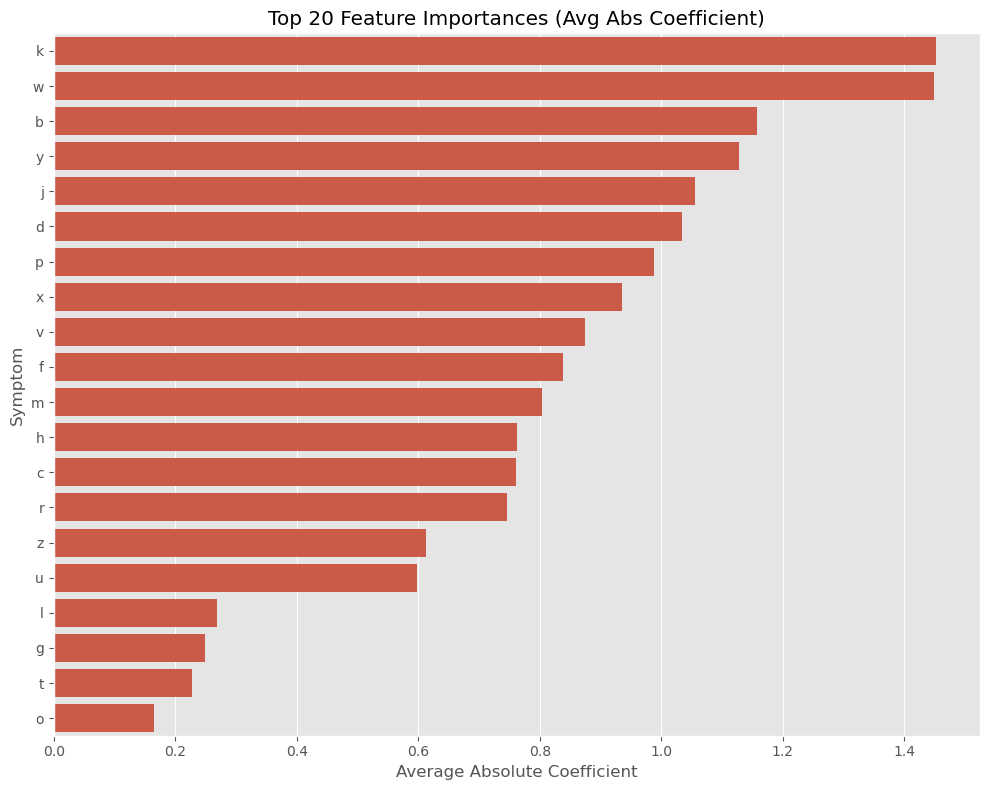

\nTop 10 Features:
   Feature  Importance
18       k    1.452237
29       w    1.448953
9        b    1.158073
31       y    1.128044
17       j    1.055029
11       d    1.034375
23       p    0.988800
30       x    0.935707
28       v    0.874081
13       f    0.838913


In [14]:
# Ensure the model is fitted
if not hasattr(clf, 'coef_'):
    print("Model not fitted yet. Fitting on training data.")
    clf.fit(X_train, y_train)

# Calculate average absolute coefficient values across classes
avg_abs_coef = np.mean(np.abs(clf.coef_), axis=0)
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': avg_abs_coef})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top N features
# Plot top N features
n_top_features = 20
plt.figure(figsize=(10, 8))
# Uses the 'Feature' column (containing symptom names) for y-axis labels
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(n_top_features))
plt.title(f'Top {n_top_features} Feature Importances (Avg Abs Coefficient)')
plt.xlabel('Average Absolute Coefficient')
plt.ylabel('Symptom') # Label confirms it should be symptoms
plt.tight_layout()
plt.show()

print("\\nTop 10 Features:")
# Prints the DataFrame, showing the 'Feature' column with symptom names
print(feature_importance.head(10))

## 9. Learning Curve Analysis

Learning curves show the validation and training score of an estimator for varying numbers of training samples. This helps to understand if the model benefits from more data or suffers from high bias or variance.

Generating Learning Curve...


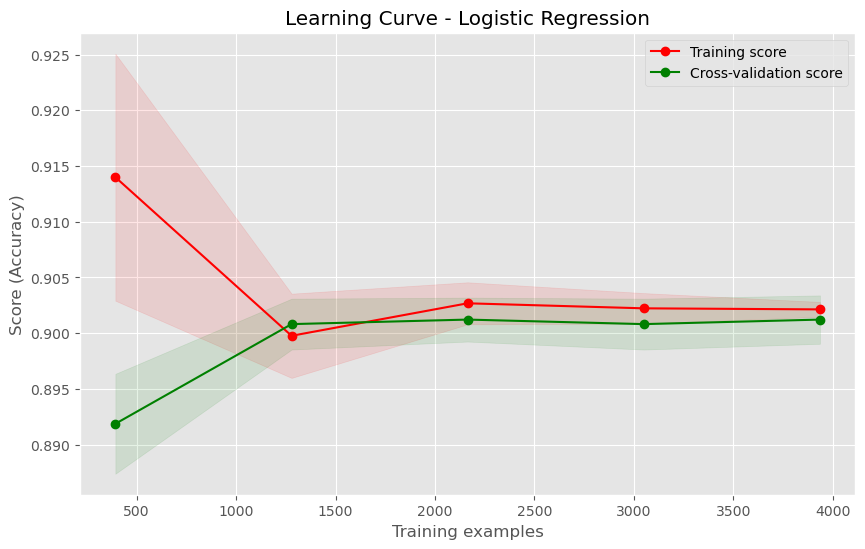

In [11]:
print("Generating Learning Curve...")
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=cv, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5), # Use 5 points between 10% and 100% of data
    scoring='accuracy' # Or another relevant metric
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training examples')
plt.ylabel('Score (Accuracy)')
plt.legend(loc="best")
plt.grid(True)
plt.show()

## 10. ROC Curve and AUC (One-vs-Rest)

Receiver Operating Characteristic (ROC) curves visualize the trade-off between the true positive rate (TPR) and false positive rate (FPR) at various threshold settings. The Area Under the Curve (AUC) provides a single measure of separability.

For multi-class problems, we plot the ROC curve for each class against the rest (One-vs-Rest approach).

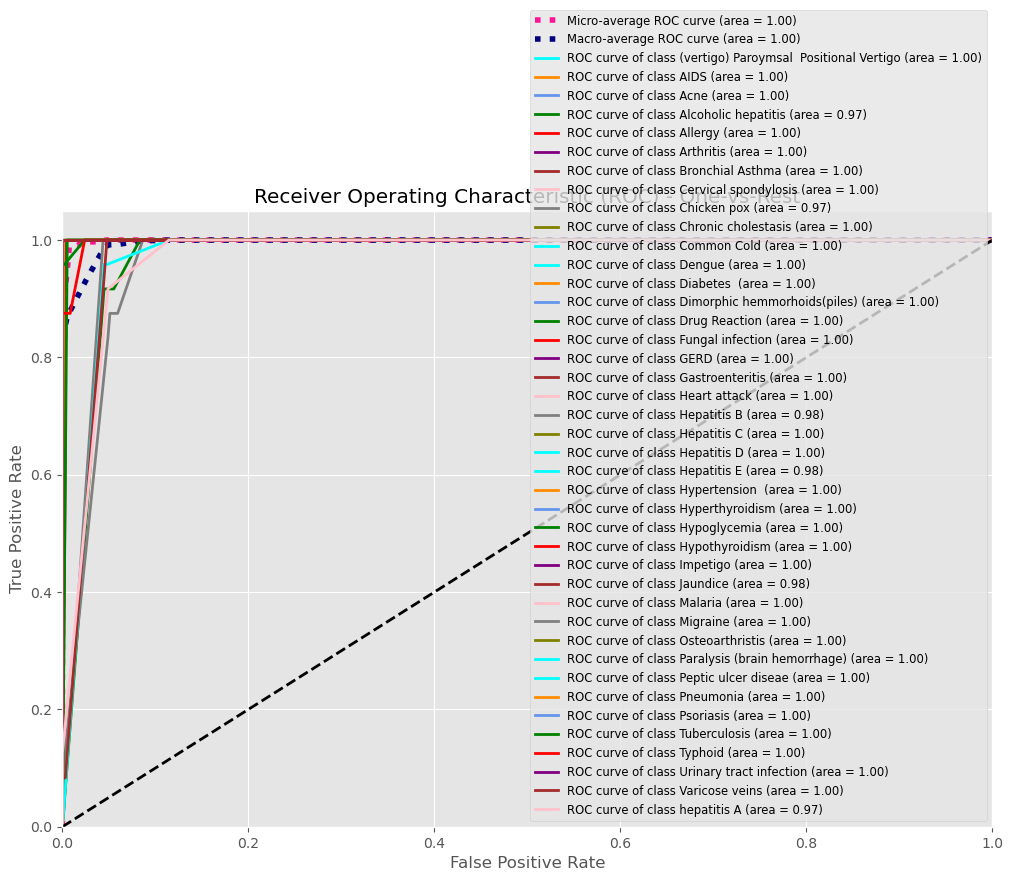


AUC Scores (One-vs-Rest):
Macro Average AUC (OvR): 0.9961
Weighted Average AUC (OvR): 0.9961


In [12]:
# Binarize the output labels for OvR ROC analysis
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
lw = 2 # line width

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
plt.legend(loc="lower right", fontsize='small') # Adjust legend position and size if needed
plt.grid(True)
plt.show()

# Calculate OvR/OvO AUC scores directly
roc_auc_ovr_macro = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
roc_auc_ovr_weighted = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

print(f"\nAUC Scores (One-vs-Rest):")
print(f"Macro Average AUC (OvR): {roc_auc_ovr_macro:.4f}")
print(f"Weighted Average AUC (OvR): {roc_auc_ovr_weighted:.4f}")

## 11. Conclusion

This notebook provided a comprehensive evaluation of the Multinomial Logistic Regression model. Key findings include:
- Cross-validation accuracy.
- Detailed performance metrics per class.
- Identification of the most influential symptoms (features).
- Assessment of model learning behavior (bias/variance trade-off).
- Evaluation of class separability using ROC/AUC.